<a href="https://colab.research.google.com/github/MrigeeshAshwin/RVFL/blob/main/Untitled16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# RVFL Pipeline with Iterative Bayesian Mask Refinement and Two-Stage Hyperparameter Tuning (Multi-Model)

import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.datasets import load_digits, load_diabetes, load_wine, fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
sns.set(style="whitegrid")

# --- Activation ---
def activation(x, task):
    return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)

# --- Graph Mask Generator ---
def generate_small_world_mask(n_features, n_hidden, k=4, p=0.3):
    G = nx.watts_strogatz_graph(n=n_features, k=k, p=p)
    mask = np.zeros((n_features, n_hidden))
    for h in range(n_hidden):
        center = np.random.choice(n_features)
        neighbors = list(G.neighbors(center)) + [center]
        mask[neighbors, h] = 1
    return mask

# --- Bayesian Solver ---
def sp_rvfl_solver_iterative(H, Y, max_iter=30, tol=1e-4, pruning_threshold=1e4, outer_iters=1):
    N, D = H.shape
    K = Y.shape[1]
    mask = np.ones(D)
    for outer in range(outer_iters):
        alpha = np.ones(D)
        sigma2 = 1.0
        eps = 1e-6
        for _ in range(max_iter):
            Alpha = np.diag(alpha)
            A = Alpha + (H.T @ H) / sigma2 + eps * np.eye(D)
            try:
                L = np.linalg.cholesky(A)
                Sigma = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(D)))
            except np.linalg.LinAlgError:
                Sigma = np.linalg.inv(A)
            Mu = Sigma @ H.T @ Y / sigma2
            gamma = 1 - alpha * np.diag(Sigma)
            gamma = np.maximum(gamma, 0)
            alpha_new = gamma / (np.sum(Mu**2, axis=1) + 1e-8)
            denom = N * K - np.sum(gamma)
            sigma2_new = np.sum((Y - H @ Mu) ** 2) / (denom if denom > 1e-8 else 1)
            if np.linalg.norm(alpha - alpha_new) < tol and abs(sigma2 - sigma2_new) < tol * sigma2:
                break
            alpha, sigma2 = alpha_new, sigma2_new
        mask = (alpha < pruning_threshold).astype(float)
        H = H * mask
    return Mu, mask

# --- Preprocessing ---
def preprocess_classification(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train_onehot, y_test_onehot, encoder, y_train, y_test

def preprocess_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train, y_test, scaler_y, y_train, y_test

# --- Core RVFL ---
def base_rvfl(X_train, y_train, X_test, n_hidden=256, W=None, b=None,
              use_sp=False, mask=None, mask_direct=None, C=1e-3, task='classification'):
    if W is None:
        W = np.random.randn(X_train.shape[1], n_hidden)
        if mask is not None:
            W *= mask
    if b is None:
        b = np.random.randn(n_hidden)

    H_train = activation(X_train @ W + b, task)
    H_test = activation(X_test @ W + b, task)

    X_train_proj = X_train @ mask_direct if mask_direct is not None else X_train
    X_test_proj = X_test @ mask_direct if mask_direct is not None else X_test

    Z_train = np.hstack([X_train_proj, H_train])
    Z_test = np.hstack([X_test_proj, H_test])

    if use_sp:
        beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train)
        Z_test = Z_test * learned_mask
    else:
        beta = np.linalg.inv(Z_train.T @ Z_train + C * np.eye(Z_train.shape[1])) @ Z_train.T @ y_train

    return Z_test @ beta

# --- Specialized RVFL Variants ---
def vanilla_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task)

def sp_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, C=C, task=task)

def sw_sp_rvfl(X_train, y_train, X_test, n_hidden=256, k=4, p=0.3, C=1e-3, task='classification'):
    mask = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, mask=mask, C=C, task=task)

def sw_sp_hidden_direct(X_train, y_train, X_test, n_hidden=256, k=4, p=0.3, C=1e-3, task='classification'):
    mask_hidden = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    mask_direct = generate_small_world_mask(X_train.shape[1], X_train.shape[1], k, p)
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, mask=mask_hidden, mask_direct=mask_direct, C=C, task=task)

# --- Grid Search and Evaluation ---
def hyperparameter_grid_search(X, y, dataset_name, task='classification'):
    models = {
        'Vanilla RVFL': vanilla_rvfl,
        'SP-RVFL': sp_rvfl,
        'SW-SP-RVFL': sw_sp_rvfl,
        'SW-SP Hidden + Direct': sw_sp_hidden_direct
    }

    neuron_options = [10, 50, 100, 256, 512]
    C_options = [1e-2, 1e-1, 1.0, 10.0]

    if task == 'classification':
        X_train_full, X_test, y_train_full, y_test, encoder, y_train_raw, y_test_raw = preprocess_classification(X, y)
        y_val_true = np.argmax(y_test, axis=1)
    else:
        X_train_full, X_test, y_train_full, y_test, scaler_y, y_train_raw, y_test_raw = preprocess_regression(X, y)
        y_val_true = scaler_y.inverse_transform(y_test)

    for model_name, model_fn in models.items():
        best_score = 0 if task == 'classification' else float('inf')
        best_params = {}

        for N in neuron_options:
            for C in C_options:
                try:
                    y_val_pred = model_fn(X_train_full, y_train_full, X_test, n_hidden=N, C=C, task=task)
                    if task == 'classification':
                        acc = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))
                        if acc > best_score:
                            best_score = acc
                            best_params = {'N': N, 'C': C}
                    else:
                        val_pred_cont = scaler_y.inverse_transform(y_val_pred)
                        rmse = np.sqrt(mean_squared_error(y_val_true, val_pred_cont))
                        if rmse < best_score:
                            best_score = rmse
                            best_params = {'N': N, 'C': C}
                except Exception as e:
                    print(f"{model_name} failed for N={N}, C={C}: {e}")

        print(f"\nBest Hyperparameters for {model_name} on {dataset_name}:")
        print(best_params)

        final_pred = model_fn(X_train_full, y_train_full, X_test, n_hidden=best_params['N'], C=best_params['C'], task=task)
        if task == 'classification':
            final_score = accuracy_score(y_val_true, np.argmax(final_pred, axis=1))
            print(f"Test Accuracy: {final_score:.4f}")
            cm = confusion_matrix(y_val_true, np.argmax(final_pred, axis=1))
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f"Confusion Matrix - {model_name} ({dataset_name})")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.show()
        else:
            test_pred_cont = scaler_y.inverse_transform(final_pred)
            final_score = np.sqrt(mean_squared_error(y_val_true, test_pred_cont))
            print(f"Test RMSE: {final_score:.4f}")

# --- Pipeline Execution ---
if __name__ == '__main__':
    X, y = fetch_california_housing(return_X_y=True)
    hyperparameter_grid_search(X, y, dataset_name="California Housing", task='regression')



Best Hyperparameters for Vanilla RVFL on California Housing:
{'N': 512, 'C': 0.1}
Test RMSE: 0.5903

Best Hyperparameters for SP-RVFL on California Housing:
{'N': 512, 'C': 10.0}
Test RMSE: 0.5811

Best Hyperparameters for SW-SP-RVFL on California Housing:
{'N': 512, 'C': 0.1}
Test RMSE: 0.5945

Best Hyperparameters for SW-SP Hidden + Direct on California Housing:
{'N': 512, 'C': 0.1}
Test RMSE: 0.5772


Params: N=64, lr=0.01, sigma=0.5, C=0.001 => RMSE=2.2874
Params: N=64, lr=0.01, sigma=0.5, C=0.01 => RMSE=3.7382
Params: N=64, lr=0.01, sigma=1.0, C=0.001 => RMSE=3.9903
Params: N=64, lr=0.01, sigma=1.0, C=0.01 => RMSE=1.6909
Params: N=64, lr=0.005, sigma=0.5, C=0.001 => RMSE=0.7220
Params: N=64, lr=0.005, sigma=0.5, C=0.01 => RMSE=0.7654
Params: N=64, lr=0.005, sigma=1.0, C=0.001 => RMSE=3.5719
Params: N=64, lr=0.005, sigma=1.0, C=0.01 => RMSE=6.3325
Params: N=128, lr=0.01, sigma=0.5, C=0.001 => RMSE=5.8581
Params: N=128, lr=0.01, sigma=0.5, C=0.01 => RMSE=3.7711
Params: N=128, lr=0.01, sigma=1.0, C=0.001 => RMSE=1.5647
Params: N=128, lr=0.01, sigma=1.0, C=0.01 => RMSE=0.6523
Params: N=128, lr=0.005, sigma=0.5, C=0.001 => RMSE=1.0868
Params: N=128, lr=0.005, sigma=0.5, C=0.01 => RMSE=0.8475
Params: N=128, lr=0.005, sigma=1.0, C=0.001 => RMSE=2.6912
Params: N=128, lr=0.005, sigma=1.0, C=0.01 => RMSE=0.6310

Best Params: {'n_hidden': 128, 'lr': 0.005, 'sigma': 1.0, 'C': 0.01}
Best Valid

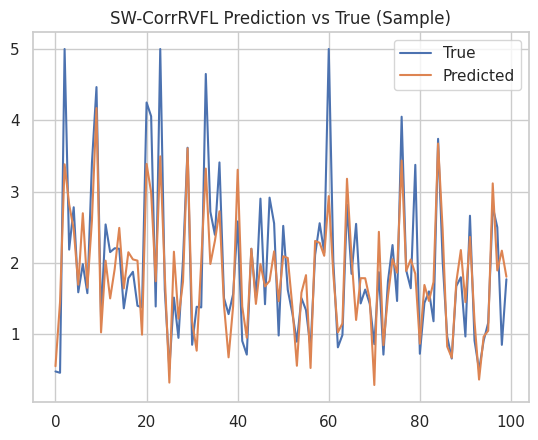

In [ ]:
# --- Custom Correntropy-based Small-World SP-RVFL (SW-CorrRVFL) ---
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

# --- Correntropy Loss and Gradient ---
def correntropy_loss(y_true, y_pred, sigma=1.0):
    error = y_pred - y_true
    return np.mean(1 - np.exp(- (error ** 2) / (2 * sigma ** 2)))

def correntropy_loss_grad(y_true, y_pred, sigma=1.0):
    error = y_pred - y_true
    return (error / (sigma ** 2)) * np.exp(- (error ** 2) / (2 * sigma ** 2))

# --- Small-World Graph Mask Generator ---
def generate_small_world_mask(n_features, n_hidden, k=4, p=0.3):
    G = nx.watts_strogatz_graph(n=n_features, k=k, p=p)
    mask = np.zeros((n_features, n_hidden))
    for h in range(n_hidden):
        center = np.random.choice(n_features)
        neighbors = list(G.neighbors(center)) + [center]
        mask[neighbors, h] = 1
    return mask

# --- Optimizer: SGD with Momentum ---
def sgd_momentum_update(beta, grad, v_prev, lr, momentum):
    v = momentum * v_prev - lr * grad
    beta += v
    return beta, v

# --- SW-CorrRVFL Model ---
def sw_corrrvfl(X_train, y_train, X_val, n_hidden=256, epochs=1000, lr=0.01, sigma=1.0, C=1e-3, k=4, p=0.3, beta1=0.9, beta2=0.999, epsilon=1e-8):
    mask = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    # --- SP-RVFL Inspired Random Weights ---
    W_raw = np.random.randn(X_train.shape[1], n_hidden)
    W_var = np.var(W_raw, axis=0, keepdims=True) + 1e-6
    W_norm = W_raw / np.sqrt(W_var)
    W = W_norm * mask
    b = np.random.randn(n_hidden)

    def activation(x):
        return np.maximum(0, x)

    H_train = activation(X_train @ W + b)
    H_val = activation(X_val @ W + b)

    Z_train = np.hstack([X_train, H_train])
    Z_val = np.hstack([X_val, H_val])

    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])
    m = np.zeros_like(beta)
    v = np.zeros_like(beta)

    for epoch in range(1, epochs + 1):
        y_pred = Z_train @ beta
        grad_loss = correntropy_loss_grad(y_train, y_pred, sigma)
        grad_beta = Z_train.T @ grad_loss / len(y_train) + C * beta

        m = beta1 * m + (1 - beta1) * grad_beta
        v = beta2 * v + (1 - beta2) * (grad_beta ** 2)
        m_hat = m / (1 - beta1 ** epoch)
        v_hat = v / (1 - beta2 ** epoch)
        beta -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

    return Z_val @ beta, beta

# --- Evaluation Pipeline with Grid Search ---
def evaluate_sw_corrrvfl():
    X, y = fetch_california_housing(return_X_y=True)
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train)
    y_val = scaler_y.transform(y_val)
    y_test = scaler_y.transform(y_test)

    param_grid = {
        'n_hidden': [64, 128],
        'lr': [0.01, 0.005],
        'sigma': [0.5, 1.0],
        'C': [1e-3, 1e-2]
    }

    best_rmse = float('inf')
    best_params = None

    for n_hidden in param_grid['n_hidden']:
        for lr in param_grid['lr']:
            for sigma in param_grid['sigma']:
                for C in param_grid['C']:
                    y_val_pred, _ = sw_corrrvfl(X_train, y_train, X_val, n_hidden=n_hidden, lr=lr, sigma=sigma, C=C)
                    y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred)
                    y_val_true = scaler_y.inverse_transform(y_val)
                    rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred_rescaled))
                    print(f"Params: N={n_hidden}, lr={lr}, sigma={sigma}, C={C} => RMSE={rmse:.4f}")
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {'n_hidden': n_hidden, 'lr': lr, 'sigma': sigma, 'C': C}

    print("\nBest Params:", best_params)
    print("Best Validation RMSE:", best_rmse)

    y_test_pred, _ = sw_corrrvfl(X_train, y_train, X_test, **best_params)
    y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
    y_test_true = scaler_y.inverse_transform(y_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_rescaled))
    print("Test RMSE:", test_rmse)

    plt.plot(y_test_true[:100], label='True')
    plt.plot(y_test_pred_rescaled[:100], label='Predicted')
    plt.title("SW-CorrRVFL Prediction vs True (Sample)")
    plt.legend()
    plt.show()

# Uncomment to run evaluation:
evaluate_sw_corrrvfl()


In [1]:
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import fetch_openml, fetch_california_housing, load_diabetes
import time
from itertools import product
import pandas as pd # Import pandas for Adult dataset preprocessing

# --- Activation Functions ---
def activation(x, task):
    """
    Applies an activation function to the input.
    For classification, uses sigmoid. For regression, uses ReLU.
    """
    return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)

# --- Graph Mask Generator ---
def generate_small_world_mask(n_features, n_hidden, k=4, p=0.3):
    """
    Generates a small-world graph-based mask for hidden layer connections.
    This creates a sparse connection pattern where each hidden neuron connects
    to a local neighborhood of input features.
    """
    # Ensure n_features is at least k for Watts-Strogatz graph
    if n_features < k:
        k = n_features - 1 if n_features > 1 else 1 # Adjust k if n_features is too small
        if k == 0: # Handle case where n_features is 1
            return np.ones((n_features, n_hidden)) # All connected if only one feature

    G = nx.watts_strogatz_graph(n=n_features, k=k, p=p, seed=42)
    mask = np.zeros((n_features, n_hidden))
    for h in range(n_hidden):
        # Randomly select a center feature for this hidden neuron
        center = np.random.choice(n_features)
        # Connect the hidden neuron to the center feature and its neighbors in the graph
        neighbors = list(G.neighbors(center)) + [center]
        # Ensure neighbors are within bounds and unique
        neighbors = list(set([n for n in neighbors if 0 <= n < n_features]))
        mask[neighbors, h] = 1
    return mask

# --- Bayesian Solver (with Adam-based Mu estimation) ---
def solve_mu_adam(H, Y, alpha, sigma2=1.0, lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8,
                  max_iter=100, tol=1e-6): # Reduced max_iter for faster grid search
    """
    Solves for Mu (posterior mean of weights) using Adam optimizer.
    This is an inner optimization loop for the SP-RVFL solver.
    """
    N, D = H.shape
    K = Y.shape[1]
    Mu = np.random.randn(D, K) * 0.01 # Initialize Mu
    m = np.zeros_like(Mu)
    v = np.zeros_like(Mu)

    for t in range(1, max_iter + 1):
        pred = H @ Mu
        error = pred - Y

        # Gradient of the Bayesian objective function with respect to Mu
        # Objective: 0.5 * ||Y - HMu||^2 / sigma2 + 0.5 * Mu.T @ Alpha @ Mu
        grad = (H.T @ error) / sigma2 + np.diag(alpha) @ Mu

        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        Mu_new = Mu - lr * m_hat / (np.sqrt(v_hat) + eps)

        if np.linalg.norm(Mu_new - Mu) < tol * np.linalg.norm(Mu):
            break
        Mu = Mu_new

    return Mu

def sp_rvfl_solver_iterative(H, Y, max_iter=30, tol=1e-4, pruning_threshold=1e4, outer_iters=1):
    """
    Iterative Bayesian Sparse Prior RVFL solver.
    Estimates the output weights (beta) and a sparsity mask by
    iteratively updating alpha (precision of weights) and sigma2 (noise variance).
    Uses Adam optimizer (solve_mu_adam) for the Mu update step.
    """
    N, D = H.shape
    K = Y.shape[1]

    for outer in range(outer_iters):
        alpha = np.ones(D) # Initialize alpha (precision of weights)
        sigma2 = 1.0       # Initial sigma2 (noise variance)
        eps = 1e-6         # Small epsilon for numerical stability

        for _ in range(max_iter):
            # Estimate Mu using ADAM optimizer
            Mu = solve_mu_adam(H, Y, alpha, sigma2, lr=1e-2) # Pass current alpha and sigma2

            # Gamma update (approximation, as calculating full Sigma is expensive)
            # This approximation is used for faster computation.
            gamma = 1 - alpha * (1 / (alpha + np.diag(H.T @ H) / sigma2 + eps)) # Approx diag(Sigma)
            gamma = np.maximum(gamma, 0) # Ensure gamma is non-negative
            alpha_new = gamma / (np.sum(Mu**2, axis=1) + eps) # Add small epsilon to denominator

            # Sigma2 update (noise variance)
            denom = N * K - np.sum(gamma)
            denom = max(denom, eps) # Ensure denominator is not zero
            sigma2_new = np.sum((Y - H @ Mu) ** 2) / denom

            if np.linalg.norm(alpha - alpha_new) < tol and abs(sigma2 - sigma2_new) < tol * sigma2:
                break

            alpha, sigma2 = alpha_new, sigma2_new

        # Apply pruning mask after outer iteration
        mask = (alpha < pruning_threshold).astype(float)
        # Re-apply mask to H for subsequent outer iterations (if outer_iters > 1)
        H = H * mask

    return Mu, mask

# --- Correntropy Loss Gradient (for Adam-based Correntropy RVFL if needed) ---
def correntropy_loss_grad(y_true, y_pred, sigma=1.0):
    """
    Calculates the gradient of the Correntropy loss with respect to y_pred.
    This function is defined for completeness but not directly used in the closed-form IRLS.
    """
    error = y_pred - y_true
    return (error / (sigma ** 2)) * np.exp(- (error ** 2) / (2 * sigma ** 2))

# --- Core RVFL Function ---
def base_rvfl(X_train, y_train, X_test, n_hidden=256, W=None, b=None,
              use_sp=False, mask=None, mask_direct=None, C=1e-3, task='classification',
              sp_pruning_threshold=1e4, sp_outer_iters=1):
    """
    Base Random Vector Functional Link (RVFL) network implementation.
    Can use a direct pseudo-inverse solution or the iterative Bayesian solver (SP-RVFL).
    Supports masking for hidden and direct connections.
    """
    # Initialize random weights (W) and biases (b) for the hidden layer if not provided
    if W is None:
        W = np.random.randn(X_train.shape[1], n_hidden)
        if mask is not None:
            W *= mask
    if b is None:
        b = np.random.randn(n_hidden)

    # Calculate hidden layer outputs
    H_train = activation(X_train @ W + b, task)
    H_test = activation(X_test @ W + b, task)

    # Apply mask to direct connection from input to output if specified
    X_train_proj = X_train @ mask_direct if mask_direct is not None else X_train
    X_test_proj = X_test @ mask_direct if mask_direct is not None else X_test

    # Concatenate direct input features and hidden layer outputs to form the Z matrix
    Z_train = np.hstack([X_train_proj, H_train])
    Z_test = np.hstack([X_test_proj, H_test])

    if use_sp:
        # Use the Bayesian Sparse Prior RVFL solver
        beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train,
                                                      pruning_threshold=sp_pruning_threshold,
                                                      outer_iters=sp_outer_iters)
        Z_test = Z_test * learned_mask # Apply the learned sparsity mask
    else:
        # Use the pseudo-inverse (ridge regression) solution
        I = np.eye(Z_train.shape[1])
        beta = np.linalg.solve(Z_train.T @ Z_train + C * I, Z_train.T @ y_train)

    return Z_test @ beta, beta # Return predictions and learned beta

# --- Specialized RVFL Variants ---
def vanilla_rvfl(X_train, y_train, X_val, n_hidden=256, C=1e-3, task='classification'):
    """Vanilla RVFL using pseudo-inverse."""
    return base_rvfl(X_train, y_train, X_val, n_hidden=n_hidden, C=C, task=task, use_sp=False)

def sp_rvfl(X_train, y_train, X_val, n_hidden=256, C=1e-3, task='classification',
            sp_pruning_threshold=1e4, sp_outer_iters=1):
    """RVFL with Bayesian Sparse Prior (SP-RVFL)."""
    return base_rvfl(X_train, y_train, X_val, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)

def sw_sp_rvfl(X_train, y_train, X_val, n_hidden=256, C=1e-3, k=4, p=0.3, task='classification',
               sp_pruning_threshold=1e4, sp_outer_iters=1):
    """RVFL with Small-World mask on hidden layer and Bayesian Sparse Prior."""
    mask = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    return base_rvfl(X_train, y_train, X_val, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     mask=mask, sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)

def sw_sp_hidden_direct(X_train, y_train, X_val, n_hidden=256, C=1e-3, k=4, p=0.3, task='classification',
                        sp_pruning_threshold=1e4, sp_outer_iters=1):
    """
    RVFL with Small-World masks on both hidden and direct connections,
    and Bayesian Sparse Prior.
    """
    mask_hidden = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    mask_direct_matrix = generate_small_world_mask(X_train.shape[1], X_train.shape[1], k, p)

    return base_rvfl(X_train, y_train, X_val, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     mask=mask_hidden, mask_direct=mask_direct_matrix,
                     sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)

# --- Closed-form Correntropy-based RVFL (IRLS) ---
def corrrvfl_closed_form(X_train, y_train, X_val, n_hidden=256, sigma=1.0, C=1e-3, max_iter=50, tol=1e-5, task='regression'):
    """
    Correntropy-based RVFL using Iteratively Reweighted Least Squares (IRLS).
    """
    n_features = X_train.shape[1]
    n_outputs = y_train.shape[1]

    # Initialize random weights and biases for the hidden layer
    W = np.random.randn(n_features, n_hidden)
    b = np.random.randn(n_hidden)

    def activation_fn(x): return np.maximum(0, x) if task == 'regression' else 1 / (1 + np.exp(-x))
    H_train = activation_fn(X_train @ W + b)
    H_val = activation_fn(X_val @ W + b)

    Z_train = np.hstack([X_train, H_train])
    Z_val = np.hstack([X_val, H_val])

    # Initial beta using small random values
    beta = np.random.randn(Z_train.shape[1], n_outputs) * 0.01

    for t in range(max_iter):
        y_pred = Z_train @ beta
        residuals = y_train - y_pred

        # Calculate weights based on Correntropy kernel
        weights = np.exp(- (residuals ** 2) / (2 * sigma ** 2))
        W_diag = np.mean(weights, axis=1) # One weight per sample
        W_matrix = np.diag(W_diag) # Diagonal weight matrix

        # Update beta using weighted least squares with regularization
        A = Z_train.T @ W_matrix @ Z_train + C * np.eye(Z_train.shape[1])
        b_vec = Z_train.T @ W_matrix @ y_train

        # Solve for new beta
        try:
            beta_new = np.linalg.solve(A, b_vec)
        except np.linalg.LinAlgError:
            # Fallback to pseudo-inverse if matrix is singular or ill-conditioned
            beta_new = np.linalg.pinv(A) @ b_vec
            print("Warning: np.linalg.solve failed, falling back to pinv.")

        # Check for convergence
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new

    return Z_val @ beta, beta

# --- Small-World Correntropy-based RVFL (IRLS) ---
def sw_corrrvfl_closed_form(X_train, y_train, X_val, n_hidden=256, sigma=1.0, C=1e-3, max_iter=50, tol=1e-5, k=4, p=0.3, task='regression'):
    """
    Correntropy-based RVFL with Small-World topology in hidden layer, using IRLS.
    """
    n_features = X_train.shape[1]
    n_outputs = y_train.shape[1]

    # Generate small-world mask for input-to-hidden weights
    mask = generate_small_world_mask(n_features, n_hidden, k, p)

    # Initialize random weights and biases for the hidden layer, applying the mask
    W = np.random.randn(n_features, n_hidden) * mask # Apply mask here
    b = np.random.randn(n_hidden)

    def activation_fn(x): return np.maximum(0, x) if task == 'regression' else 1 / (1 + np.exp(-x))
    H_train = activation_fn(X_train @ W + b)
    H_val = activation_fn(X_val @ W + b)

    Z_train = np.hstack([X_train, H_train])
    Z_val = np.hstack([X_val, H_val])

    beta = np.random.randn(Z_train.shape[1], n_outputs) * 0.01

    for t in range(max_iter):
        y_pred = Z_train @ beta
        residuals = y_train - y_pred

        weights = np.exp(- (residuals ** 2) / (2 * sigma ** 2))
        W_diag = np.mean(weights, axis=1)
        W_matrix = np.diag(W_diag)

        A = Z_train.T @ W_matrix @ Z_train + C * np.eye(Z_train.shape[1])
        b_vec = Z_train.T @ W_matrix @ y_train

        try:
            beta_new = np.linalg.solve(A, b_vec)
        except np.linalg.LinAlgError:
            beta_new = np.linalg.pinv(A) @ b_vec
            print("Warning: np.linalg.solve failed, falling back to pinv.")

        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new

    return Z_val @ beta, beta


# --- Data Loader ---
def load_dataset(name='mnist'):
    """
    Loads and preprocesses specified datasets.
    Includes train, validation, and test splits, scaling, and target binarization.
    """
    print(f"\n--- Loading Dataset: {name} ---")
    X, y, scaler_X, scaler_y, task_type = None, None, None, None, None

    if name == 'mnist':
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
        X = X / 255.0
        y = y.astype(int)
        y_processed = LabelBinarizer().fit_transform(y)
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y_processed, test_size=10000, stratify=y, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.2, stratify=np.argmax(y_train_full, axis=1), random_state=42)
        scaler_X = StandardScaler().fit(X_train)
        task_type = 'classification'
    elif name == 'california_housing':
        X, y = fetch_california_housing(return_X_y=True)
        y = y.reshape(-1, 1)
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
        scaler_X = StandardScaler().fit(X_train)
        scaler_y = StandardScaler().fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_val = scaler_y.transform(y_val)
        y_test = scaler_y.transform(y_test)
        task_type = 'regression'
    elif name == 'letter':
        X, y = fetch_openml(name='letter', version=1, return_X_y=True, as_frame=False)
        y = LabelBinarizer().fit_transform(y)
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.2, stratify=y_train_full.argmax(axis=1), random_state=42)
        scaler_X = StandardScaler().fit(X_train)
        task_type = 'classification'
    elif name == 'diabetes': # Added Diabetes dataset
        X, y = load_diabetes(return_X_y=True)
        y = y.reshape(-1, 1)
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
        scaler_X = StandardScaler().fit(X_train)
        scaler_y = StandardScaler().fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_val = scaler_y.transform(y_val)
        y_test = scaler_y.transform(y_test)
        task_type = 'regression'
    elif name == 'adult': # Added Adult UCI dataset
        # Load the dataset from UCI ML Repository
        data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'education-num',
            'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
        ]
        df = pd.read_csv(data_url, header=None, names=column_names, sep=r',\s*', na_values='?', engine='python')
        df.dropna(inplace=True) # Drop rows with missing values

        # Separate features (X) and target (y)
        X_df = df.drop('income', axis=1)
        y_series = df['income']

        # One-hot encode categorical features
        categorical_cols = X_df.select_dtypes(include='object').columns
        X_df = pd.get_dummies(X_df, columns=categorical_cols, drop_first=True) # drop_first to avoid multicollinearity

        # Convert target to binary (0 or 1)
        # Ensure consistent mapping: <=50K -> 0, >50K -> 1
        label_map = {'<=50K': 0, '>50K': 1}
        y_encoded = y_series.map(label_map).values

        # Convert X to numpy array
        X = X_df.values
        y = y_encoded

        # Split data
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

        # Scale numerical features (assuming numerical columns are now all of X)
        # After get_dummies, all columns are numerical, so scale all features in X
        scaler_X = StandardScaler().fit(X_train)

        # Convert y to one-hot for classification models
        lb = LabelBinarizer()
        y_train = lb.fit_transform(y_train)
        y_val = lb.transform(y_val)
        y_test = lb.transform(y_test)

        scaler_y = None # No y scaling for classification
        task_type = 'classification'

    else:
        raise ValueError(f"Dataset '{name}' not supported.")

    X_train = scaler_X.transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)

    print(f"Data loaded. Task: {task_type}. Train shape: {X_train.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y, task_type

# --- Evaluation Pipeline ---
def run_evaluation(dataset_name, model_type='corrrvfl_closed_form'):
    """
    Runs hyperparameter grid search and evaluates the specified RVFL model.
    """
    X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y, task_type = load_dataset(dataset_name)

    # Define parameter grids for each model type
    model_fn = None
    if model_type == 'corrrvfl_closed_form':
        param_grid = {
            'n_hidden': [128, 256, 512],
            'C': [1e-3, 1e-2],
            'sigma': [0.5, 1.0]
        }
        model_fn = corrrvfl_closed_form
    elif model_type == 'sw_corrrvfl_closed_form':
        param_grid = {
            'n_hidden': [128, 256],
            'C': [1e-3, 1e-2],
            'sigma': [0.5, 1.0],
            'k': [2, 4],
            'p': [0.1, 0.3]
        }
        model_fn = sw_corrrvfl_closed_form
    elif model_type == 'vanilla_rvfl':
        param_grid = {
            'n_hidden': [128, 256, 512],
            'C': [1e-1, 1.0]
        }
        model_fn = vanilla_rvfl
    elif model_type == 'sp_rvfl':
        param_grid = {
            'n_hidden': [128, 256],
            'C': [1e-3, 1e-2], # C is still passed to base_rvfl but not used by sp_rvfl_solver_iterative
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1]
        }
        model_fn = sp_rvfl
    elif model_type == 'sw_sp_rvfl':
        param_grid = {
            'n_hidden': [128, 256],
            'C': [1e-3, 1e-2],
            'k': [2, 4],
            'p': [0.1, 0.3],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1]
        }
        model_fn = sw_sp_rvfl
    elif model_type == 'sw_sp_hidden_direct':
        param_grid = {
            'n_hidden': [128, 256],
            'C': [1e-3, 1e-2],
            'k': [2, 4],
            'p': [0.1, 0.3],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1]
        }
        model_fn = sw_sp_hidden_direct
    else:
        raise ValueError(f"Model type '{model_type}' not supported.")

    keys = list(param_grid.keys())
    best_score = -1 if task_type == 'classification' else float('inf')
    best_params = None

    print(f"\n--- Grid Search: {model_type} on {dataset_name} ---")
    start_time = time.time()

    # Iterate over all parameter combinations
    for combo in product(*param_grid.values()):
        params = dict(zip(keys, combo))
        print(f"Testing: {params}")

        # Call the appropriate model function
        # Pass task_type to model functions
        y_val_pred, _ = model_fn(X_train, y_train, X_val, task=task_type, **params)

        if task_type == 'classification':
            y_pred_labels = np.argmax(y_val_pred, axis=1)
            y_true_labels = np.argmax(y_val, axis=1)
            score = accuracy_score(y_true_labels, y_pred_labels)
            print(f" -> Validation Accuracy: {score:.4f}")
            if score > best_score:
                best_score = score
                best_params = params
        else: # Regression
            # Rescale predictions and true values back to original scale for RMSE calculation
            y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred)
            y_val_true_rescaled = scaler_y.inverse_transform(y_val)
            score = np.sqrt(mean_squared_error(y_val_true_rescaled, y_val_pred_rescaled))
            print(f" -> Validation RMSE: {score:.4f}")
            if score < best_score:
                best_score = score
                best_params = params

    print(f"\nBest Params for {model_type}: {best_params}")
    print(f"Best Validation {'Accuracy' if task_type == 'classification' else 'RMSE'}: {best_score:.4f}")
    print(f"Grid Search Time: {time.time() - start_time:.2f}s")

    # Final training on full training + validation data with best parameters
    X_train_full_combined = np.vstack([X_train, X_val])
    y_train_full_combined = np.vstack([y_train, y_val])

    print("\n--- Final Training on Full Data and Test Evaluation ---")
    # Pass task_type to model functions for final evaluation as well
    final_y_test_pred, _ = model_fn(X_train_full_combined, y_train_full_combined, X_test, task=task_type, **best_params)

    if task_type == 'classification':
        final_test_pred_labels = np.argmax(final_y_test_pred, axis=1)
        final_test_true_labels = np.argmax(y_test, axis=1)
        final_score = accuracy_score(final_test_true_labels, final_test_pred_labels)
        print(f"FINAL TEST ACCURACY for {model_type}: {final_score:.4f}")
    else: # Regression
        final_test_pred_rescaled = scaler_y.inverse_transform(final_y_test_pred)
        final_test_true_rescaled = scaler_y.inverse_transform(y_test)
        final_score = np.sqrt(mean_squared_error(final_test_true_rescaled, final_test_pred_rescaled))
        print(f"FINAL TEST RMSE for {model_type}: {final_score:.4f}")

    return final_score, best_params

# --- Main Execution ---
if __name__ == '__main__':
    # Define datasets and models to run
    datasets = {
        'classification': ['mnist', 'letter', 'adult'],
        'regression': ['california_housing', 'diabetes']
    }

    models_to_test = [
        'vanilla_rvfl',
        'corrrvfl_closed_form',
        'sw_corrrvfl_closed_form',
        'sp_rvfl', # Re-added SP-RVFL
        'sw_sp_rvfl', # Re-added Small-World SP-RVFL
        'sw_sp_hidden_direct' # Re-added Small-World Hidden + Direct SP-RVFL
    ]

    all_results = {}

    for task_type, dataset_list in datasets.items():
        for dataset_name in dataset_list:
            print(f"\n{'='*50}\nRunning on Dataset: {dataset_name} ({task_type})\n{'='*50}")
            dataset_results = {}
            for model_name in models_to_test:
                print(f"\n{'*'*40}\nRunning Model: {model_name}\n{'*'*40}")
                try:
                    score, params = run_evaluation(dataset_name, model_name)
                    dataset_results[model_name] = {'score': score, 'params': params}
                except ValueError as e:
                    print(f"Skipping {model_name} on {dataset_name} due to: {e}")
                except Exception as e:
                    print(f"An error occurred for {model_name} on {dataset_name}: {e}")
            all_results[dataset_name] = dataset_results

    print("\n\n=============== ALL EXPERIMENTS SUMMARY ===============")
    for dataset, models_res in all_results.items():
        print(f"\nDataset: {dataset}")
        for model, res in models_res.items():
            # Determine the correct metric name based on the dataset's task type
            current_task_type = 'classification' if dataset in datasets['classification'] else 'regression'
            metric_name = "Accuracy" if current_task_type == 'classification' else "RMSE"
            print(f"  {model}: Final Test {metric_name} = {res['score']:.4f}, Best Params = {res['params']}")



Running on Dataset: mnist (classification)

****************************************
Running Model: vanilla_rvfl
****************************************

--- Loading Dataset: mnist ---
Data loaded. Task: classification. Train shape: (48000, 784)

--- Grid Search: vanilla_rvfl on mnist ---
Testing: {'n_hidden': 128, 'C': 0.1}


/tmp/ipython-input-1-989301789.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)


 -> Validation Accuracy: 0.8646
Testing: {'n_hidden': 128, 'C': 1.0}


/tmp/ipython-input-1-989301789.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)


 -> Validation Accuracy: 0.8650
Testing: {'n_hidden': 256, 'C': 0.1}


/tmp/ipython-input-1-989301789.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)


 -> Validation Accuracy: 0.8767
Testing: {'n_hidden': 256, 'C': 1.0}


/tmp/ipython-input-1-989301789.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)


 -> Validation Accuracy: 0.8743
Testing: {'n_hidden': 512, 'C': 0.1}


/tmp/ipython-input-1-989301789.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)


 -> Validation Accuracy: 0.8848
Testing: {'n_hidden': 512, 'C': 1.0}


/tmp/ipython-input-1-989301789.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)


 -> Validation Accuracy: 0.8901

Best Params for vanilla_rvfl: {'n_hidden': 512, 'C': 1.0}
Best Validation Accuracy: 0.8901
Grid Search Time: 39.89s

--- Final Training on Full Data and Test Evaluation ---


/tmp/ipython-input-1-989301789.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)


FINAL TEST ACCURACY for vanilla_rvfl: 0.8848

****************************************
Running Model: corrrvfl_closed_form
****************************************

--- Loading Dataset: mnist ---
Data loaded. Task: classification. Train shape: (48000, 784)

--- Grid Search: corrrvfl_closed_form on mnist ---
Testing: {'n_hidden': 128, 'C': 0.001, 'sigma': 0.5}


/tmp/ipython-input-1-989301789.py:215: RuntimeWarning: overflow encountered in exp
  def activation_fn(x): return np.maximum(0, x) if task == 'regression' else 1 / (1 + np.exp(-x))


KeyboardInterrupt: 

# CorrRVFL run on ADAM optimizer



--- Running Grid Search for Vanilla RVFL on California Housing ---

Best Hyperparameters for Vanilla RVFL on California Housing:
{'N': 256, 'C': 0.01}
Test RMSE: 0.6052

--- Running Grid Search for Correntropy-Adam RVFL on California Housing ---

Best Hyperparameters for Correntropy-Adam RVFL on California Housing:
{'N': 50, 'epochs': 100, 'lr': 0.1, 'sigma_correntropy': 2.0}
Test RMSE: 0.8966

--- Regression Results Summary ---
Vanilla RVFL: Best Score = 0.5971, Best Params = {'N': 256, 'C': 0.01}
Correntropy-Adam RVFL: Best Score = 0.7661, Best Params = {'N': 50, 'epochs': 100, 'lr': 0.1, 'sigma_correntropy': 2.0}


--- Running Classification Example (Adult UCI Dataset) ---

--- Running Grid Search for Vanilla RVFL on Adult UCI ---

Best Hyperparameters for Vanilla RVFL on Adult UCI:
{'N': 128, 'C': 1.0}
Test Accuracy: 0.8404


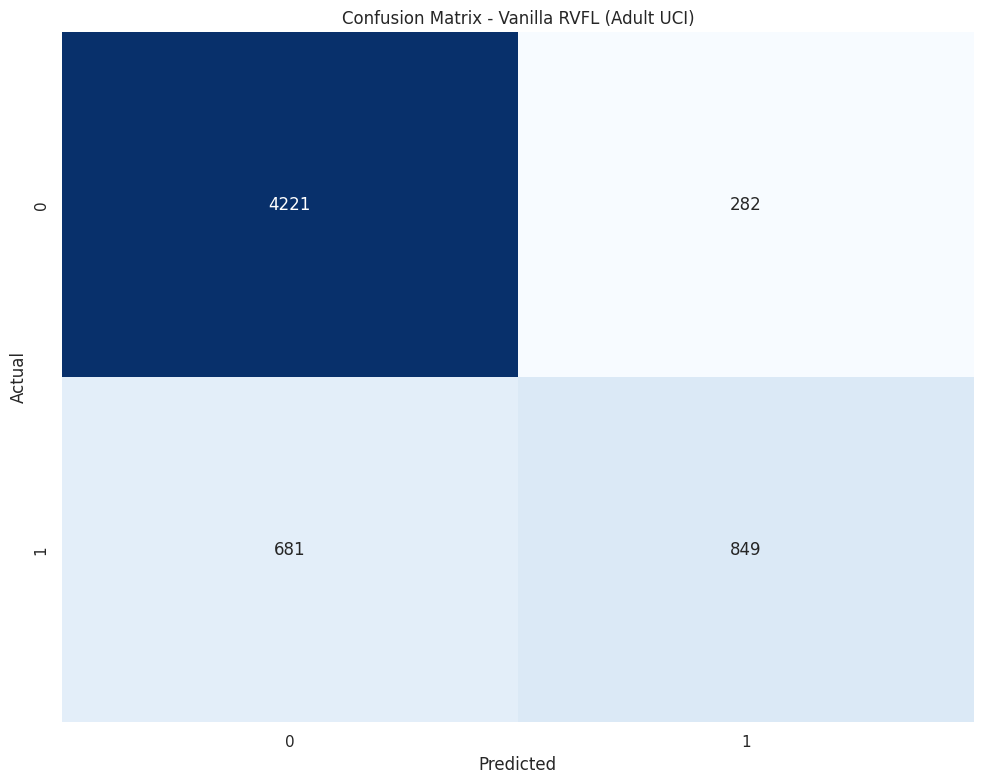


--- Running Grid Search for Correntropy-Adam RVFL on Adult UCI ---

Best Hyperparameters for Correntropy-Adam RVFL on Adult UCI:
{'N': 50, 'epochs': 150, 'lr': 0.1, 'sigma_correntropy': 2.0}
Test Accuracy: 0.8268


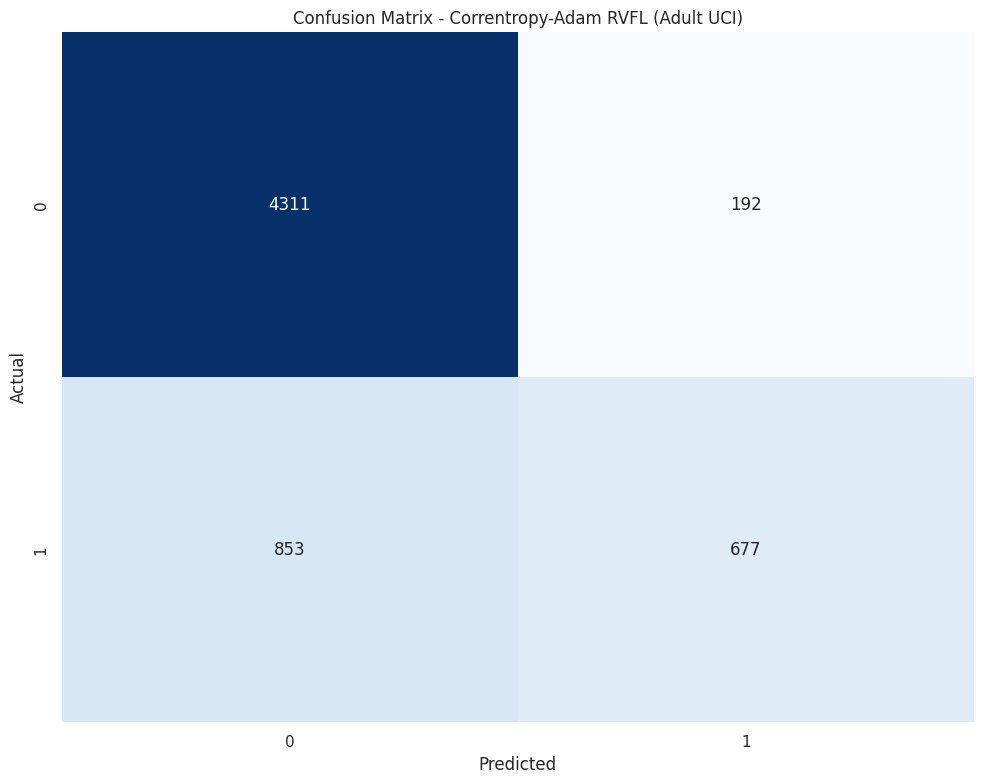


--- Adult UCI Classification Results Summary ---
Vanilla RVFL: Best Score = 0.8425, Best Params = {'N': 128, 'C': 1.0}
Correntropy-Adam RVFL: Best Score = 0.8155, Best Params = {'N': 50, 'epochs': 150, 'lr': 0.1, 'sigma_correntropy': 2.0}


In [28]:
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.datasets import load_digits, load_diabetes, load_wine, fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
sns.set(style="whitegrid")

# --- Activation Functions ---
def activation(x, task):
    """
    Applies an activation function to the input.
    For classification, uses sigmoid. For regression, uses ReLU.
    """
    return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)

# --- Graph Mask Generator (kept for completeness, but not used in selected models) ---
def generate_small_world_mask(n_features, n_hidden, k=4, p=0.3):
    """
    Generates a small-world graph-based mask for hidden layer connections.
    This creates a sparse connection pattern where each hidden neuron connects
    to a local neighborhood of input features.
    """
    G = nx.watts_strogatz_graph(n=n_features, k=k, p=p)
    mask = np.zeros((n_features, n_hidden))
    for h in range(n_hidden):
        center = np.random.choice(n_features)
        neighbors = list(G.neighbors(center)) + [center]
        mask[neighbors, h] = 1
    return mask

# --- Bayesian Solver (kept for completeness, but not used in selected models) ---
def sp_rvfl_solver_iterative(H, Y, max_iter=30, tol=1e-4, pruning_threshold=1e4, outer_iters=1):
    """
    Iterative Bayesian Sparse Prior RVFL solver.
    Estimates the output weights (beta) and a sparsity mask by
    iteratively updating alpha (precision of weights) and sigma2 (noise variance).
    """
    N, D = H.shape  # N: number of samples, D: number of features in H
    K = Y.shape[1]  # K: number of output dimensions

    for outer in range(outer_iters):
        alpha = np.ones(D)  # Initial precision for each weight
        sigma2 = 1.0        # Initial noise variance
        eps = 1e-6          # Small epsilon for numerical stability

        for _ in range(max_iter):
            Alpha = np.diag(alpha)  # Diagonal matrix of precisions
            A = Alpha + (H.T @ H) / sigma2 + eps * np.eye(D)

            try:
                L = np.linalg.cholesky(A)
                Sigma = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(D)))
            except np.linalg.LinAlgError:
                Sigma = np.linalg.inv(A)

            Mu = Sigma @ H.T @ Y / sigma2
            gamma = 1 - alpha * np.diag(Sigma)
            gamma = np.maximum(gamma, 0)
            alpha_new = gamma / (np.sum(Mu**2, axis=1) + 1e-8)
            denom = N * K - np.sum(gamma)
            sigma2_new = np.sum((Y - H @ Mu) ** 2) / (denom if denom > 1e-8 else 1)

            if np.linalg.norm(alpha - alpha_new) < tol and abs(sigma2 - sigma2_new) < tol * sigma2:
                break

            alpha, sigma2 = alpha_new, sigma2_new

        mask = (alpha < pruning_threshold).astype(float)
        H = H * mask

    return Mu, mask

# --- Preprocessing Functions ---
def preprocess_classification(X, y):
    """
    Preprocesses data for classification tasks: splits, scales features,
    and one-hot encodes labels.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train_onehot, y_test_onehot, encoder, y_train, y_test

def preprocess_regression(X, y):
    """
    Preprocesses data for regression tasks: splits, scales features and labels.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train, y_test, scaler_y, y_train, y_test

# --- Core RVFL Function ---
def base_rvfl(X_train, y_train, X_test, n_hidden=256, W=None, b=None,
              use_sp=False, mask=None, mask_direct=None, C=1e-3, task='classification'):
    """
    Base Random Vector Functional Link (RVFL) network implementation.
    Can use a direct pseudo-inverse solution or the iterative Bayesian solver (SP-RVFL).
    Supports masking for hidden and direct connections.
    """
    # Initialize random weights (W) and biases (b) for the hidden layer if not provided
    if W is None:
        W = np.random.randn(X_train.shape[1], n_hidden)
        if mask is not None:
            W *= mask
    if b is None:
        b = np.random.randn(n_hidden)

    # Calculate hidden layer outputs
    H_train = activation(X_train @ W + b, task)
    H_test = activation(X_test @ W + b, task)

    # Apply mask to direct connection from input to output if specified
    X_train_proj = X_train @ mask_direct if mask_direct is not None else X_train
    X_test_proj = X_test @ mask_direct if mask_direct is not None else X_test

    # Concatenate direct input features and hidden layer outputs to form the Z matrix
    Z_train = np.hstack([X_train_proj, H_train])
    Z_test = np.hstack([X_test_proj, H_test])

    if use_sp:
        beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train)
        Z_test = Z_test * learned_mask
    else:
        beta = np.linalg.inv(Z_train.T @ Z_train + C * np.eye(Z_train.shape[1])) @ Z_train.T @ y_train

    return Z_test @ beta

# --- Specialized RVFL Variants (kept for completeness, but not used in selected models) ---
def vanilla_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    """Vanilla RVFL using pseudo-inverse."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task)

def sp_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    """RVFL with Bayesian Sparse Prior (SP-RVFL)."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, C=C, task=task)

def sw_sp_rvfl(X_train, y_train, X_test, n_hidden=256, k=4, p=0.3, C=1e-3, task='classification'):
    """RVFL with Small-World mask on hidden layer and Bayesian Sparse Prior."""
    mask = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, mask=mask, C=C, task=task)

def sw_sp_hidden_direct(X_train, y_train, X_test, n_hidden=256, k=4, p=0.3, C=1e-3, task='classification'):
    """
    RVFL with Small-World masks on both hidden and direct connections,
    and Bayesian Sparse Prior.
    """
    mask_hidden = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    mask_direct_matrix = generate_small_world_mask(X_train.shape[1], X_train.shape[1], k, p)

    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, mask=mask_hidden, mask_direct=mask_direct_matrix, C=C, task=task)


# --- Loss Functions for Adam Optimization ---

def tukey_loss(y_true, y_pred, c=4.685):
    """
    Calculates the Tukey's Biweight loss.
    c: tuning constant, typically 4.685 for 95% efficiency relative to squared error.
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    loss = np.zeros_like(r, dtype=float)

    mask_inside = abs_r <= c
    loss[mask_inside] = (c**2 / 2) * (1 - (1 - (r[mask_inside]/c)**2)**3)
    loss[~mask_inside] = c**2 / 2

    return np.sum(loss)

def tukey_loss_gradient(y_true, y_pred, c=4.685):
    """
    Calculates the gradient of the Tukey's Biweight loss with respect to y_pred.
    dL/dy_pred = - dL/dr (where r = y_true - y_pred)
    dL/dr = -3r * (1 - (r/c)^2)^2 if |r| <= c, else 0
    So, dL/dy_pred = 3r * (1 - (r/c)^2)^2 if |r| <= c, else 0
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    grad = np.zeros_like(r, dtype=float)

    mask_inside = abs_r <= c
    r_inside = r[mask_inside]

    grad[mask_inside] = 3 * r_inside * (1 - (r_inside/c)**2)**2

    return grad


def hawkeye_loss(y_true, y_pred, epsilon=0.1, sigma=0.5, kappa=1.0):
    """
    Calculates the HawkEye loss.
    A simplified piecewise representation based on the general description:
    L(r) = 0                               if |r| <= epsilon
    L(r) = (1/2) * ( ( |r| - epsilon ) / sigma )^2 * kappa  if epsilon < |r| <= epsilon + sigma
    L(r) = kappa / 2                                        if |r| > epsilon + sigma
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    loss = np.zeros_like(r, dtype=float)

    mask_quad = (abs_r > epsilon) & (abs_r <= epsilon + sigma)
    res_quad = abs_r[mask_quad] - epsilon
    loss[mask_quad] = (0.5 * (res_quad / sigma)**2) * kappa

    mask_bounded = abs_r > (epsilon + sigma)
    loss[mask_bounded] = kappa / 2

    return np.sum(loss)

def hawkeye_loss_gradient(y_true, y_pred, epsilon=0.1, sigma=0.5, kappa=1.0):
    """
    Calculates the gradient of the HawkEye loss with respect to y_pred.
    dL/dy_pred = -dL/dr (where r = y_true - y_pred)

    Based on the simplified piecewise representation:
    If |r| <= epsilon: dL/dr = 0 => dL/dy_pred = 0
    If epsilon < |r| <= epsilon + sigma: dL/dr = ( ( |r| - epsilon ) / (sigma^2) ) * sign(r) * kappa
                                        => dL/dy_pred = - ( ( |r| - epsilon ) / (sigma^2) ) * sign(r) * kappa
    If |r| > epsilon + sigma: dL/dr = 0 => dL/dy_pred = 0
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    grad = np.zeros_like(r, dtype=float)

    sign_r = np.sign(r)

    mask_quad = (abs_r > epsilon) & (abs_r <= epsilon + sigma)
    res_quad = abs_r[mask_quad] - epsilon
    grad[mask_quad] = - (res_quad / (sigma**2)) * sign_r[mask_quad] * kappa

    return grad


def correntropy_loss(y_true, y_pred, sigma=1.0):
    """
    Calculates the Correntropy loss.
    L(e) = 1 - exp(-e^2 / (2*sigma^2)), where e is the error (y_true - y_pred).
    sigma: kernel width parameter for the Gaussian kernel.
    """
    e = y_true - y_pred
    loss = 1 - np.exp(-e**2 / (2 * sigma**2))
    return np.sum(loss)

def correntropy_loss_gradient(y_true, y_pred, sigma=1.0):
    """
    Calculates the gradient of the Correntropy loss with respect to y_pred.
    dL/dy_pred = - (e / sigma^2) * exp(-e^2 / (2*sigma^2)), where e = y_true - y_pred.
    """
    e = y_true - y_pred
    grad = - (e / sigma**2) * np.exp(-e**2 / (2 * sigma**2))
    return grad

# --- Fuzzy Transformation (kept for completeness, but not used in selected models) ---
def fuzzy_transform(X, num_fuzzy_sets_per_feature=3):
    """
    Transforms crisp input features into fuzzy membership degrees.
    Uses simple triangular membership functions.
    Returns a new feature matrix with fuzzy memberships.
    """
    fuzzy_features_list = []

    for i in range(X.shape[1]):
        feature_data = X[:, i]
        min_val, max_val = np.min(feature_data), np.max(feature_data)

        if np.isclose(min_val, max_val):
            fuzzy_features_list.append(np.ones((X.shape[0], num_fuzzy_sets_per_feature)) / num_fuzzy_sets_per_feature)
            continue

        if num_fuzzy_sets_per_feature == 3:
            centers = [min_val, (min_val + max_val) / 2, max_val]
            spread = (max_val - min_val) / 2
        else:
            centers = np.linspace(min_val, max_val, num_fuzzy_sets_per_feature)
            spread = (max_val - min_val) / (num_fuzzy_sets_per_feature - 1) if num_fuzzy_sets_per_feature > 1 else 1.0

        feature_fuzzy_memberships = []
        for j in range(num_fuzzy_sets_per_feature):
            c = centers[j]
            if spread == 0:
                membership = np.where(np.isclose(feature_data, c), 1.0, 0.0)
            else:
                membership = np.maximum(0, 1 - np.abs(feature_data - c) / spread)
            feature_fuzzy_memberships.append(membership.reshape(-1, 1))

        fuzzy_features_list.append(np.hstack(feature_fuzzy_memberships))

    return np.hstack(fuzzy_features_list)


# --- RVFL Variants with Adam Optimization (kept for completeness, but not used in selected models) ---

def fuzzy_tukey_sp_adam_rvfl(X_train, y_train, X_test, n_hidden=256, c_tukey=4.685,
                             learning_rate=0.001, n_epochs=100,
                             num_fuzzy_sets_per_feature=3,
                             beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                             task='regression'):
    """
    RVFL variant incorporating:
    - Fuzzy Logic for input feature transformation.
    - SP-RVFL for initial output weight determination and sparsity.
    - Adam Optimizer to refine output weights using Tukey Loss.
    """

    X_train_fuzzy = fuzzy_transform(X_train, num_fuzzy_sets_per_feature)
    X_test_fuzzy = fuzzy_transform(X_test, num_fuzzy_sets_per_feature)
    X_train_combined = np.hstack([X_train, X_train_fuzzy])
    X_test_combined = np.hstack([X_test, X_test_fuzzy])

    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    initial_beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train)
    Z_train_masked = Z_train * learned_mask
    Z_test_masked = Z_test * learned_mask
    beta = initial_beta.copy()

    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = tukey_loss_gradient(y_train, predictions, c=c_tukey)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta

def fuzzy_tukey_adam_rvfl(X_train, y_train, X_test, n_hidden=256, c_tukey=4.685,
                          learning_rate=0.001, n_epochs=100,
                          num_fuzzy_sets_per_feature=3,
                          beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                          task='regression'):
    """
    RVFL variant incorporating:
    - Fuzzy Logic for input feature transformation.
    - Adam Optimizer to refine output weights using Tukey Loss.
    - NO SP-RVFL component for initial weight determination or sparsity.
    """

    X_train_fuzzy = fuzzy_transform(X_train, num_fuzzy_sets_per_feature)
    X_test_fuzzy = fuzzy_transform(X_test, num_fuzzy_sets_per_feature)
    X_train_combined = np.hstack([X_train, X_train_fuzzy])
    X_test_combined = np.hstack([X_test, X_test_fuzzy])

    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])

    Z_train_masked = Z_train
    Z_test_masked = Z_test

    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = tukey_loss_gradient(y_train, predictions, c=c_tukey)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta


def hawkeye_adam_rvfl(X_train, y_train, X_test, n_hidden=256,
                            epsilon_hawkeye=0.1, sigma_hawkeye=0.5, kappa_hawkeye=1.0,
                            learning_rate=0.001, n_epochs=100,
                            beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                            task='regression'):
    """
    RVFL variant incorporating:
    - Adam Optimizer to refine output weights using HawkEye Loss.
    - NO Fuzzy Logic component for input feature transformation.
    - NO SP-RVFL component for initial weight determination or sparsity.
    """

    X_train_combined = X_train
    X_test_combined = X_test

    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])

    Z_train_masked = Z_train
    Z_test_masked = Z_test

    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = hawkeye_loss_gradient(y_train, predictions,
                                           epsilon=epsilon_hawkeye, sigma=sigma_hawkeye, kappa=kappa_hawkeye)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta


def correntropy_adam_rvfl(X_train, y_train, X_test, n_hidden=256,
                          sigma_correntropy=1.0,
                          learning_rate=0.001, n_epochs=100,
                          beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                          task='regression'):
    """
    RVFL variant incorporating:
    - Adam Optimizer to refine output weights using Correntropy Loss.
    - NO Fuzzy Logic component for input feature transformation.
    - NO SP-RVFL component for initial weight determination or sparsity.
    """

    # 1. No Fuzzy Transformation - Use original X_train, X_test directly
    X_train_combined = X_train
    X_test_combined = X_test

    # 2. Random Weights and Biases for Hidden Layer
    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    # Form the Z matrix
    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    # 3. Initialize Output Weights (beta) randomly
    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])

    Z_train_masked = Z_train # No masking from SP
    Z_test_masked = Z_test   # No masking from SP

    # 4. Adam Optimization with Correntropy Loss
    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = correntropy_loss_gradient(y_train, predictions, sigma=sigma_correntropy)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta


# --- Data Loading and Preprocessing for Adult UCI Dataset ---
def load_and_preprocess_adult_dataset(data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"):
    """
    Loads and preprocesses the Adult UCI dataset.
    Handles missing values, categorical features, and scales numerical features.
    """
    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]

    # Load the dataset
    df = pd.read_csv(data_url, header=None, names=column_names, sep=r',\s*', na_values='?', engine='python')

    # Drop rows with missing values for simplicity
    df.dropna(inplace=True)

    # Separate features (X) and target (y)
    X = df.drop('income', axis=1)
    y = df['income']

    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include='object').columns.tolist()

    # Preprocess numerical features
    scaler = StandardScaler()
    X_numerical_scaled = scaler.fit_transform(X[numerical_cols])
    X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=numerical_cols, index=X.index)

    # Preprocess categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_categorical_encoded = encoder.fit_transform(X[categorical_cols])
    X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)

    # Combine preprocessed features
    X_processed = pd.concat([X_numerical_scaled_df, X_categorical_encoded_df], axis=1)

    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y) # 0 for <=50K, 1 for >50K

    return X_processed.values, y_encoded, label_encoder # Return X as numpy array

# --- Grid Search and Evaluation ---
def hyperparameter_grid_search(X, y, dataset_name, task='classification'):
    """
    Performs grid search for hyperparameters across different RVFL models
    and evaluates their performance.
    """
    models = {
        'Vanilla RVFL': vanilla_rvfl,
        'Correntropy-Adam RVFL': correntropy_adam_rvfl # New Correntropy model
    }

    # Common hyperparameter options
    neuron_options = [10, 50, 128, 256] # Reduced for faster grid search demonstration
    C_options = [1e-2, 1.0, 10] # Reduced for faster grid search demonstration

    # Specific options for Adam-optimized models
    adam_n_epochs_options = [20, 50, 100, 150] # Reduced epochs for faster demo
    adam_lr_options = [10 ,1, 0.1, 0.01, 0.001]
    # adam_num_fuzzy_sets_options is removed as fuzzy is not used in selected models

    # Specific options for Correntropy loss
    correntropy_sigma_options = [0.5, 1.0, 2.0]


    if task == 'classification':
        X_train_full, X_test, y_train_onehot, y_test_onehot, encoder, y_train_raw, y_test_raw = preprocess_classification(X, y)
        y_val_true = y_test_raw # Use raw labels for accuracy_score
        y_train_for_models = y_train_onehot # Use one-hot for model training
        y_test_for_models = y_test_onehot # Use one-hot for model prediction
    else: # Regression
        X_train_full, X_test, y_train_full, y_test, scaler_y, y_train_raw, y_test_raw = preprocess_regression(X, y)
        y_val_true = scaler_y.inverse_transform(y_test) # Inverse transform for true test labels
        y_train_for_models = y_train_full # Scaled y for model training
        y_test_for_models = y_test # Scaled y for model prediction


    results = {}

    for model_name, model_fn in models.items():
        print(f"\n--- Running Grid Search for {model_name} on {dataset_name} ---")
        best_score = 0 if task == 'classification' else float('inf') # Maximize accuracy, minimize RMSE
        best_params = {}

        # Determine hyperparameter options based on the model
        if model_name == 'Vanilla RVFL':
            for N in neuron_options:
                for C in C_options:
                    try:
                        y_val_pred = model_fn(X_train_full, y_train_for_models, X_test, n_hidden=N, C=C, task=task)
                        if task == 'classification':
                            acc = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))
                            if acc > best_score:
                                best_score = acc
                                best_params = {'N': N, 'C': C}
                        else: # Regression
                            val_pred_cont = scaler_y.inverse_transform(y_val_pred)
                            rmse = np.sqrt(mean_squared_error(y_val_true, val_pred_cont))
                            if rmse < best_score:
                                best_score = rmse
                                best_params = {'N': N, 'C': C}
                    except Exception as e:
                        print(f"  {model_name} failed for N={N}, C={C}: {e}")
        elif model_name == 'Correntropy-Adam RVFL': # New Correntropy model
            for N in neuron_options:
                for epochs in adam_n_epochs_options:
                    for lr in adam_lr_options:
                        for sigma_corr in correntropy_sigma_options:
                            try:
                                y_train_full_2d = y_train_for_models if y_train_for_models.ndim > 1 else y_train_for_models.reshape(-1, 1)
                                y_val_pred = model_fn(
                                    X_train_full, y_train_full_2d, X_test,
                                    n_hidden=N, sigma_correntropy=sigma_corr,
                                    learning_rate=lr, n_epochs=epochs,
                                    task=task
                                )
                                if task == 'classification':
                                    acc = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))
                                    if acc > best_score:
                                        best_score = acc
                                        best_params = {'N': N, 'epochs': epochs, 'lr': lr, 'sigma_correntropy': sigma_corr}
                                else: # Regression
                                    val_pred_cont = scaler_y.inverse_transform(y_val_pred)
                                    rmse = np.sqrt(mean_squared_error(y_val_true, val_pred_cont))
                                    if rmse < best_score:
                                        best_score = rmse
                                        best_params = {'N': N, 'epochs': epochs, 'lr': lr, 'sigma_correntropy': sigma_corr}
                            except Exception as e:
                                print(f"  {model_name} failed for N={N}, epochs={epochs}, lr={lr}, sigma_correntropy={sigma_corr}: {e}")

        results[model_name] = {'best_score': best_score, 'best_params': best_params}
        print(f"\nBest Hyperparameters for {model_name} on {dataset_name}:")
        print(best_params)

        # Final evaluation with best parameters
        if model_name == 'Vanilla RVFL':
            final_pred = model_fn(X_train_full, y_train_for_models, X_test, n_hidden=best_params['N'], C=best_params['C'], task=task)
        elif model_name == 'Correntropy-Adam RVFL':
            y_train_full_2d = y_train_for_models if y_train_for_models.ndim > 1 else y_train_for_models.reshape(-1, 1)
            final_pred = model_fn(
                X_train_full, y_train_full_2d, X_test,
                n_hidden=best_params['N'], sigma_correntropy=best_params['sigma_correntropy'],
                learning_rate=best_params['lr'], n_epochs=best_params['epochs'],
                task=task
            )

        if task == 'classification':
            final_score = accuracy_score(y_val_true, np.argmax(final_pred, axis=1))
            print(f"Test Accuracy: {final_score:.4f}")
            cm = confusion_matrix(y_val_true, np.argmax(final_pred, axis=1))
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f"Confusion Matrix - {model_name} ({dataset_name})")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.show()
        else: # Regression
            test_pred_cont = scaler_y.inverse_transform(final_pred)
            final_score = np.sqrt(mean_squared_error(y_val_true, test_pred_cont))
            print(f"Test RMSE: {final_score:.4f}")

    return results

# --- Pipeline Execution ---
if __name__ == '__main__':
    # Load a regression dataset for demonstration
    X, y = fetch_california_housing(return_X_y=True)

    # Run the hyperparameter grid search including the new model
    results_regression = hyperparameter_grid_search(X, y, dataset_name="California Housing", task='regression')
    print("\n--- Regression Results Summary ---")
    for model_name, res in results_regression.items():
        print(f"{model_name}: Best Score = {res['best_score']:.4f}, Best Params = {res['best_params']}")

    # Load and preprocess Adult UCI dataset
    X_adult, y_adult, adult_label_encoder = load_and_preprocess_adult_dataset()

    # Run the hyperparameter grid search for Adult UCI dataset (classification)
    print("\n\n--- Running Classification Example (Adult UCI Dataset) ---")
    results_adult_classification = hyperparameter_grid_search(X_adult, y_adult, dataset_name="Adult UCI", task='classification')
    print("\n--- Adult UCI Classification Results Summary ---")
    for model_name, res in results_adult_classification.items():
        print(f"{model_name}: Best Score = {res['best_score']:.4f}, Best Params = {res['best_params']}")


# CorrRVFL run on NAG optimization


--- Running Grid Search for Vanilla RVFL on California Housing ---

Best Hyperparameters for Vanilla RVFL on California Housing:
{'N': 256, 'C': 0.01}
Test RMSE: 0.6052

--- Running Grid Search for Correntropy-Adam RVFL on California Housing ---

Best Hyperparameters for Correntropy-Adam RVFL on California Housing:
{'N': 50, 'epochs': 100, 'lr': 0.1, 'sigma_correntropy': 2.0}
Test RMSE: 0.8966

--- Running Grid Search for Correntropy-NAG RVFL on California Housing ---

Best Hyperparameters for Correntropy-NAG RVFL on California Housing:
{'N': 10, 'epochs': 20, 'lr': 0.001, 'sigma_correntropy': 1.0, 'momentum': 0.8}
Test RMSE: 82.1196

--- Regression Results Summary ---
Vanilla RVFL: Best Score = 0.5971, Best Params = {'N': 256, 'C': 0.01}
Correntropy-Adam RVFL: Best Score = 0.7661, Best Params = {'N': 50, 'epochs': 100, 'lr': 0.1, 'sigma_correntropy': 2.0}
Correntropy-NAG RVFL: Best Score = 7.8193, Best Params = {'N': 10, 'epochs': 20, 'lr': 0.001, 'sigma_correntropy': 1.0, 'momentum'

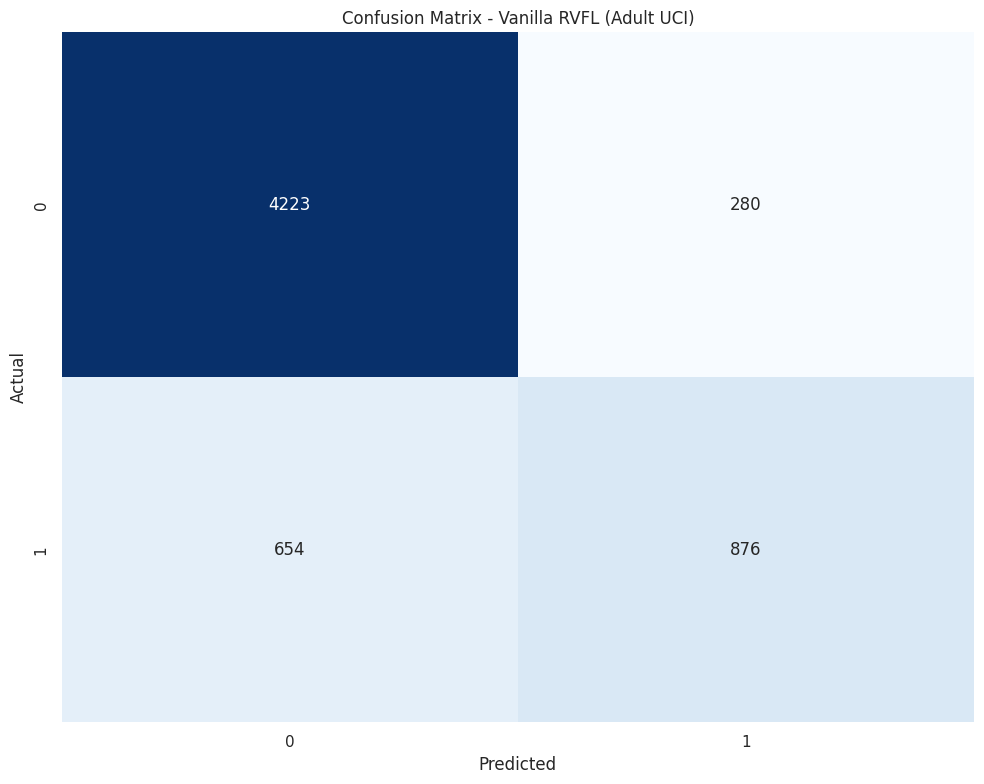


--- Running Grid Search for Correntropy-Adam RVFL on Adult UCI ---

Best Hyperparameters for Correntropy-Adam RVFL on Adult UCI:
{'N': 10, 'epochs': 150, 'lr': 0.1, 'sigma_correntropy': 2.0}
Test Accuracy: 0.7890


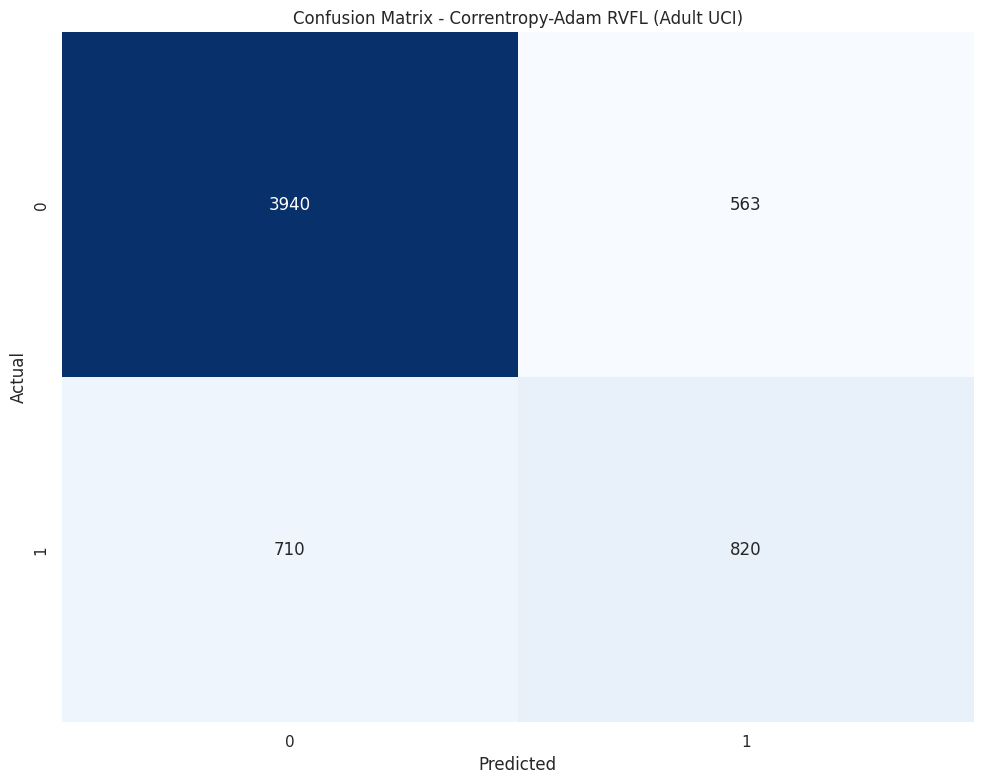


--- Running Grid Search for Correntropy-NAG RVFL on Adult UCI ---


In [ ]:
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.datasets import load_digits, load_diabetes, load_wine, fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
sns.set(style="whitegrid")

# --- Activation Functions ---
def activation(x, task):
    """
    Applies an activation function to the input.
    For classification, uses sigmoid. For regression, uses ReLU.
    """
    return 1 / (1 + np.exp(-x)) if task == 'classification' else np.maximum(0, x)

# --- Graph Mask Generator (kept for completeness, but not used in selected models) ---
def generate_small_world_mask(n_features, n_hidden, k=4, p=0.3):
    """
    Generates a small-world graph-based mask for hidden layer connections.
    This creates a sparse connection pattern where each hidden neuron connects
    to a local neighborhood of input features.
    """
    if n_features == 0 or n_hidden == 0:
        return np.zeros((n_features, n_hidden))

    k_adjusted = min(k, n_features - 1)
    if k_adjusted <= 0 and n_features > 1: k_adjusted = 1
    elif n_features == 1 and k_adjusted == 0: k_adjusted = 1 # special case for single feature graph

    G = nx.watts_strogatz_graph(n=n_features, k=k_adjusted, p=p)
    mask = np.zeros((n_features, n_hidden))
    for h in range(n_hidden):
        center = np.random.choice(n_features)
        neighbors = list(G.neighbors(center)) + [center]
        mask[neighbors, h] = 1
    return mask

# --- Bayesian Solver (kept for completeness, but not used in selected models) ---
def sp_rvfl_solver_iterative(H, Y, max_iter=30, tol=1e-4, pruning_threshold=1e4, outer_iters=1):
    """
    Iterative Bayesian Sparse Prior RVFL solver.
    Estimates the output weights (beta) and a sparsity mask by
    iteratively updating alpha (precision of weights) and sigma2 (noise variance).
    """
    N, D = H.shape  # N: number of samples, D: number of features in H
    K = Y.shape[1]  # K: number of output dimensions

    for outer in range(outer_iters):
        alpha = np.ones(D)  # Initial precision for each weight
        sigma2 = 1.0        # Initial noise variance
        eps = 1e-6          # Small epsilon for numerical stability

        for _ in range(max_iter):
            Alpha = np.diag(alpha)  # Diagonal matrix of precisions
            A = Alpha + (H.T @ H) / sigma2 + eps * np.eye(D)

            try:
                L = np.linalg.cholesky(A)
                Sigma = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(D)))
            except np.linalg.LinAlgError:
                Sigma = np.linalg.inv(A)

            Mu = Sigma @ H.T @ Y / sigma2
            gamma = 1 - alpha * np.diag(Sigma)
            gamma = np.maximum(gamma, 0)
            alpha_new = gamma / (np.sum(Mu**2, axis=1) + 1e-8)
            denom = N * K - np.sum(gamma)
            sigma2_new = np.sum((Y - H @ Mu) ** 2) / (denom if denom > 1e-8 else 1)

            if np.linalg.norm(alpha - alpha_new) < tol and abs(sigma2 - sigma2_new) < tol * sigma2:
                break

            alpha, sigma2 = alpha_new, sigma2_new

        mask = (alpha < pruning_threshold).astype(float)
        H = H * mask

    return Mu, mask

# --- Preprocessing Functions ---
def preprocess_classification(X, y):
    """
    Preprocesses data for classification tasks: splits, scales features,
    and one-hot encodes labels.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train_onehot, y_test_onehot, encoder, y_train, y_test

def preprocess_regression(X, y):
    """
    Preprocesses data for regression tasks: splits, scales features and labels.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train, y_test, scaler_y, y_train, y_test

# --- Core RVFL Function ---
def base_rvfl(X_train, y_train, X_test, n_hidden=256, W=None, b=None,
              use_sp=False, mask=None, mask_direct=None, C=1e-3, task='classification'):
    """
    Base Random Vector Functional Link (RVFL) network implementation.
    Can use a direct pseudo-inverse solution or the iterative Bayesian solver (SP-RVFL).
    Supports masking for hidden and direct connections.
    """
    # Initialize random weights (W) and biases (b) for the hidden layer if not provided
    if W is None:
        W = np.random.randn(X_train.shape[1], n_hidden)
        if mask is not None:
            W *= mask
    if b is None:
        b = np.random.randn(n_hidden)

    # Calculate hidden layer outputs
    H_train = activation(X_train @ W + b, task)
    H_test = activation(X_test @ W + b, task)

    # Apply mask to direct connection from input to output if specified
    X_train_proj = X_train @ mask_direct if mask_direct is not None else X_train
    X_test_proj = X_test @ mask_direct if mask_direct is not None else X_test

    # Concatenate direct input features and hidden layer outputs to form the Z matrix
    Z_train = np.hstack([X_train_proj, H_train])
    Z_test = np.hstack([X_test_proj, H_test])

    if use_sp:
        beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train)
        Z_test = Z_test * learned_mask
    else:
        beta = np.linalg.inv(Z_train.T @ Z_train + C * np.eye(Z_train.shape[1])) @ Z_train.T @ y_train

    return Z_test @ beta

# --- Specialized RVFL Variants (kept for completeness, but not used in selected models) ---
def vanilla_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    """Vanilla RVFL using pseudo-inverse."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task)

def sp_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    """RVFL with Bayesian Sparse Prior (SP-RVFL)."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, C=C, task=task)

def sw_sp_rvfl(X_train, y_train, X_test, n_hidden=256, k=4, p=0.3, C=1e-3, task='classification'):
    """RVFL with Small-World mask on hidden layer and Bayesian Sparse Prior."""
    mask = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, mask=mask, C=C, task=task)

def sw_sp_hidden_direct(X_train, y_train, X_test, n_hidden=256, k=4, p=0.3, C=1e-3, task='classification'):
    """
    RVFL with Small-World masks on both hidden and direct connections,
    and Bayesian Sparse Prior.
    """
    mask_hidden = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    mask_direct_matrix = generate_small_world_mask(X_train.shape[1], X_train.shape[1], k, p)

    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, use_sp=True, mask=mask_hidden, mask_direct=mask_direct_matrix, C=C, task=task)


# --- Loss Functions for Adam Optimization ---

def tukey_loss(y_true, y_pred, c=4.685):
    """
    Calculates the Tukey's Biweight loss.
    c: tuning constant, typically 4.685 for 95% efficiency relative to squared error.
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    loss = np.zeros_like(r, dtype=float)

    mask_inside = abs_r <= c
    loss[mask_inside] = (c**2 / 2) * (1 - (1 - (r[mask_inside]/c)**2)**3)
    loss[~mask_inside] = c**2 / 2

    return np.sum(loss)

def tukey_loss_gradient(y_true, y_pred, c=4.685):
    """
    Calculates the gradient of the Tukey's Biweight loss with respect to y_pred.
    dL/dy_pred = - dL/dr (where r = y_true - y_pred)
    dL/dr = -3r * (1 - (r/c)^2)^2 if |r| <= c, else 0
    So, dL/dy_pred = 3r * (1 - (r/c)^2)^2 if |r| <= c, else 0
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    grad = np.zeros_like(r, dtype=float)

    mask_inside = abs_r <= c
    r_inside = r[mask_inside]

    grad[mask_inside] = 3 * r_inside * (1 - (r_inside/c)**2)**2

    return grad


def hawkeye_loss(y_true, y_pred, epsilon=0.1, sigma=0.5, kappa=1.0):
    """
    Calculates the HawkEye loss.
    A simplified piecewise representation based on the general description:
    L(r) = 0                                       if |r| <= epsilon
    L(r) = (1/2) * ( ( |r| - epsilon ) / sigma )^2 * kappa  if epsilon < |r| <= epsilon + sigma
    L(r) = kappa / 2                                        if |r| > epsilon + sigma
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    loss = np.zeros_like(r, dtype=float)

    mask_quad = (abs_r > epsilon) & (abs_r <= epsilon + sigma)
    res_quad = abs_r[mask_quad] - epsilon
    loss[mask_quad] = (0.5 * (res_quad / sigma)**2) * kappa

    mask_bounded = abs_r > (epsilon + sigma)
    loss[mask_bounded] = kappa / 2

    return np.sum(loss)

def hawkeye_loss_gradient(y_true, y_pred, epsilon=0.1, sigma=0.5, kappa=1.0):
    """
    Calculates the gradient of the HawkEye loss with respect to y_pred.
    dL/dy_pred = -dL/dr (where r = y_true - y_pred)

    Based on the simplified piecewise representation:
    If |r| <= epsilon: dL/dr = 0 => dL/dy_pred = 0
    If epsilon < |r| <= epsilon + sigma: dL/dr = ( ( |r| - epsilon ) / (sigma^2) ) * sign(r) * kappa
                                         => dL/dy_pred = - ( ( |r| - epsilon ) / (sigma^2) ) * sign(r) * kappa
    If |r| > epsilon + sigma: dL/dr = 0 => dL/dy_pred = 0
    """
    r = y_true - y_pred
    abs_r = np.abs(r)
    grad = np.zeros_like(r, dtype=float)

    sign_r = np.sign(r)

    mask_quad = (abs_r > epsilon) & (abs_r <= epsilon + sigma)
    res_quad = abs_r[mask_quad] - epsilon
    grad[mask_quad] = - (res_quad / (sigma**2)) * sign_r[mask_quad] * kappa

    return grad


def correntropy_loss(y_true, y_pred, sigma=1.0):
    """
    Calculates the Correntropy loss.
    L(e) = 1 - exp(-e^2 / (2*sigma^2)), where e is the error (y_true - y_pred).
    sigma: kernel width parameter for the Gaussian kernel.
    """
    e = y_true - y_pred
    loss = 1 - np.exp(-e**2 / (2 * sigma**2))
    return np.sum(loss)

def correntropy_loss_gradient(y_true, y_pred, sigma=1.0):
    """
    Calculates the gradient of the Correntropy loss with respect to y_pred.
    dL/dy_pred = - (e / sigma^2) * exp(-e^2 / (2*sigma^2)), where e = y_true - y_pred.
    """
    e = y_true - y_pred
    grad = - (e / sigma**2) * np.exp(-e**2 / (2 * sigma**2))
    return grad

# --- Fuzzy Transformation (kept for completeness, but not used in selected models) ---
def fuzzy_transform(X, num_fuzzy_sets_per_feature=3):
    """
    Transforms crisp input features into fuzzy membership degrees.
    Uses simple triangular membership functions.
    Returns a new feature matrix with fuzzy memberships.
    """
    fuzzy_features_list = []

    for i in range(X.shape[1]):
        feature_data = X[:, i]
        min_val, max_val = np.min(feature_data), np.max(feature_data)

        if np.isclose(min_val, max_val):
            fuzzy_features_list.append(np.ones((X.shape[0], num_fuzzy_sets_per_feature)) / num_fuzzy_sets_per_feature)
            continue

        if num_fuzzy_sets_per_feature == 3:
            centers = [min_val, (min_val + max_val) / 2, max_val]
            spread = (max_val - min_val) / 2
        else:
            centers = np.linspace(min_val, max_val, num_fuzzy_sets_per_feature)
            spread = (max_val - min_val) / (num_fuzzy_sets_per_feature - 1) if num_fuzzy_sets_per_feature > 1 else 1.0

        feature_fuzzy_memberships = []
        for j in range(num_fuzzy_sets_per_feature):
            c = centers[j]
            if spread == 0:
                membership = np.where(np.isclose(feature_data, c), 1.0, 0.0)
            else:
                membership = np.maximum(0, 1 - np.abs(feature_data - c) / spread)
            feature_fuzzy_memberships.append(membership.reshape(-1, 1))

        fuzzy_features_list.append(np.hstack(feature_fuzzy_memberships))

    return np.hstack(fuzzy_features_list)


# --- RVFL Variants with Adam Optimization (kept for completeness, but not used in selected models) ---

def fuzzy_tukey_sp_adam_rvfl(X_train, y_train, X_test, n_hidden=256, c_tukey=4.685,
                             learning_rate=0.001, n_epochs=100,
                             num_fuzzy_sets_per_feature=3,
                             beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                             task='regression'):
    """
    RVFL variant incorporating:
    - Fuzzy Logic for input feature transformation.
    - SP-RVFL for initial output weight determination and sparsity.
    - Adam Optimizer to refine output weights using Tukey Loss.
    """

    X_train_fuzzy = fuzzy_transform(X_train, num_fuzzy_sets_per_feature)
    X_test_fuzzy = fuzzy_transform(X_test, num_fuzzy_sets_per_feature)
    X_train_combined = np.hstack([X_train, X_train_fuzzy])
    X_test_combined = np.hstack([X_test, X_test_fuzzy])

    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    initial_beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train)
    Z_train_masked = Z_train * learned_mask
    Z_test_masked = Z_test * learned_mask
    beta = initial_beta.copy()

    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = tukey_loss_gradient(y_train, predictions, c=c_tukey)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta

def fuzzy_tukey_adam_rvfl(X_train, y_train, X_test, n_hidden=256, c_tukey=4.685,
                           learning_rate=0.001, n_epochs=100,
                           num_fuzzy_sets_per_feature=3,
                           beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                           task='regression'):
    """
    RVFL variant incorporating:
    - Fuzzy Logic for input feature transformation.
    - Adam Optimizer to refine output weights using Tukey Loss.
    - NO SP-RVFL component for initial weight determination or sparsity.
    """

    X_train_fuzzy = fuzzy_transform(X_train, num_fuzzy_sets_per_feature)
    X_test_fuzzy = fuzzy_transform(X_test, num_fuzzy_sets_per_feature)
    X_train_combined = np.hstack([X_train, X_train_fuzzy])
    X_test_combined = np.hstack([X_test, X_test_fuzzy])

    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])

    Z_train_masked = Z_train
    Z_test_masked = Z_test

    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = tukey_loss_gradient(y_train, predictions, c=c_tukey)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta


def hawkeye_adam_rvfl(X_train, y_train, X_test, n_hidden=256,
                      epsilon_hawkeye=0.1, sigma_hawkeye=0.5, kappa_hawkeye=1.0,
                      learning_rate=0.001, n_epochs=100,
                      beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                      task='regression'):
    """
    RVFL variant incorporating:
    - Adam Optimizer to refine output weights using HawkEye Loss.
    - NO Fuzzy Logic component for input feature transformation.
    - NO SP-RVFL component for initial weight determination or sparsity.
    """

    X_train_combined = X_train
    X_test_combined = X_test

    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])

    Z_train_masked = Z_train
    Z_test_masked = Z_test

    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = hawkeye_loss_gradient(y_train, predictions,
                                           epsilon=epsilon_hawkeye, sigma=sigma_hawkeye, kappa=kappa_hawkeye)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta


def correntropy_adam_rvfl(X_train, y_train, X_test, n_hidden=256,
                          sigma_correntropy=1.0,
                          learning_rate=0.001, n_epochs=100,
                          beta1=0.9, beta2=0.999, epsilon_adam=1e-8,
                          task='regression'):
    """
    RVFL variant incorporating:
    - Adam Optimizer to refine output weights using Correntropy Loss.
    - NO Fuzzy Logic component for input feature transformation.
    - NO SP-RVFL component for initial weight determination or sparsity.
    """

    # 1. No Fuzzy Transformation - Use original X_train, X_test directly
    X_train_combined = X_train
    X_test_combined = X_test

    # 2. Random Weights and Biases for Hidden Layer
    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    # Form the Z matrix
    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    # 3. Initialize Output Weights (beta) randomly
    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])

    Z_train_masked = Z_train # No masking from SP
    Z_test_masked = Z_test   # No masking from SP

    # 4. Adam Optimization with Correntropy Loss
    m_t = np.zeros_like(beta)
    v_t = np.zeros_like(beta)

    for epoch in range(1, n_epochs + 1):
        predictions = Z_train_masked @ beta
        dL_dy_pred = correntropy_loss_gradient(y_train, predictions, sigma=sigma_correntropy)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        m_t = beta1 * m_t + (1 - beta1) * grad_beta
        v_t = beta2 * v_t + (1 - beta2) * (grad_beta**2)

        m_hat = m_t / (1 - beta1**epoch)
        v_hat = v_t / (1 - beta2**epoch)

        beta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

    return Z_test_masked @ beta

# --- NEW: Correntropy RVFL with NAG Optimization ---
def correntropy_nag_rvfl(X_train, y_train, X_test, n_hidden=256,
                         sigma_correntropy=1.0,
                         learning_rate=0.001, n_epochs=100,
                         momentum=0.9, # Momentum parameter for NAG
                         task='regression'):
    """
    RVFL variant incorporating:
    - Nesterov Accelerated Gradient (NAG) Optimizer to refine output weights using Correntropy Loss.
    - NO Fuzzy Logic component for input feature transformation.
    - NO SP-RVFL component for initial weight determination or sparsity.
    """

    X_train_combined = X_train
    X_test_combined = X_test

    W = np.random.randn(X_train_combined.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H_train = activation(X_train_combined @ W + b, task)
    H_test = activation(X_test_combined @ W + b, task)

    Z_train = np.hstack([X_train_combined, H_train])
    Z_test = np.hstack([X_test_combined, H_test])

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    beta = np.random.randn(Z_train.shape[1], y_train.shape[1])
    velocity = np.zeros_like(beta) # Initialize velocity for NAG

    Z_train_masked = Z_train
    Z_test_masked = Z_test

    for epoch in range(n_epochs):
        # Look-ahead point for gradient calculation
        beta_lookahead = beta - momentum * velocity

        # Calculate predictions and gradient at the look-ahead point
        predictions_lookahead = Z_train_masked @ beta_lookahead
        dL_dy_pred = correntropy_loss_gradient(y_train, predictions_lookahead, sigma=sigma_correntropy)
        grad_beta = Z_train_masked.T @ dL_dy_pred

        # Update velocity and weights
        velocity = momentum * velocity + learning_rate * grad_beta
        beta -= velocity

    return Z_test_masked @ beta


# --- Data Loading and Preprocessing for Adult UCI Dataset ---
def load_and_preprocess_adult_dataset(data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"):
    """
    Loads and preprocesses the Adult UCI dataset.
    Handles missing values, categorical features, and scales numerical features.
    """
    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]

    # Load the dataset
    df = pd.read_csv(data_url, header=None, names=column_names, sep=r',\s*', na_values='?', engine='python')

    # Drop rows with missing values for simplicity
    df.dropna(inplace=True)

    # Separate features (X) and target (y)
    X = df.drop('income', axis=1)
    y = df['income']

    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include='object').columns.tolist()

    # Preprocess numerical features
    scaler = StandardScaler()
    X_numerical_scaled = scaler.fit_transform(X[numerical_cols])
    X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=numerical_cols, index=X.index)

    # Preprocess categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_categorical_encoded = encoder.fit_transform(X[categorical_cols])
    X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)

    # Combine preprocessed features
    X_processed = pd.concat([X_numerical_scaled_df, X_categorical_encoded_df], axis=1)

    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y) # 0 for <=50K, 1 for >50K

    return X_processed.values, y_encoded, label_encoder # Return X as numpy array

# --- Grid Search and Evaluation ---
def hyperparameter_grid_search(X, y, dataset_name, task='classification'):
    """
    Performs grid search for hyperparameters across different RVFL models
    and evaluates their performance.
    """
    models = {
        'Vanilla RVFL': vanilla_rvfl,
        'Correntropy-Adam RVFL': correntropy_adam_rvfl,
        'Correntropy-NAG RVFL': correntropy_nag_rvfl # Added NAG model
    }

    # Common hyperparameter options
    neuron_options = [10, 50, 128, 256]
    C_options = [1e-2, 1.0, 10]

    # Specific options for Adam/NAG-optimized models
    adam_nag_n_epochs_options = [20, 50, 100, 150]
    adam_nag_lr_options = [10 ,1, 0.1, 0.01, 0.001]

    # Specific options for Correntropy loss
    correntropy_sigma_options = [0.5, 1.0, 2.0]

    # Specific options for NAG
    nag_momentum_options = [0.5, 0.8, 0.9, 0.95]


    if task == 'classification':
        X_train_full, X_test, y_train_onehot, y_test_onehot, encoder, y_train_raw, y_test_raw = preprocess_classification(X, y)
        y_val_true = y_test_raw
        y_train_for_models = y_train_onehot
        y_test_for_models = y_test_onehot
    else: # Regression
        X_train_full, X_test, y_train_full, y_test, scaler_y, y_train_raw, y_test_raw = preprocess_regression(X, y)
        y_val_true = scaler_y.inverse_transform(y_test)
        y_train_for_models = y_train_full
        y_test_for_models = y_test


    results = {}

    for model_name, model_fn in models.items():
        print(f"\n--- Running Grid Search for {model_name} on {dataset_name} ---")
        best_score = 0 if task == 'classification' else float('inf')
        best_params = {}

        # Determine hyperparameter options based on the model
        if model_name == 'Vanilla RVFL':
            for N in neuron_options:
                for C in C_options:
                    try:
                        y_val_pred = model_fn(X_train_full, y_train_for_models, X_test, n_hidden=N, C=C, task=task)
                        if task == 'classification':
                            acc = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))
                            if acc > best_score:
                                best_score = acc
                                best_params = {'N': N, 'C': C}
                        else: # Regression
                            val_pred_cont = scaler_y.inverse_transform(y_val_pred)
                            rmse = np.sqrt(mean_squared_error(y_val_true, val_pred_cont))
                            if rmse < best_score:
                                best_score = rmse
                                best_params = {'N': N, 'C': C}
                    except Exception as e:
                        print(f"   {model_name} failed for N={N}, C={C}: {e}")
        elif model_name == 'Correntropy-Adam RVFL':
            for N in neuron_options:
                for epochs in adam_nag_n_epochs_options:
                    for lr in adam_nag_lr_options:
                        for sigma_corr in correntropy_sigma_options:
                            try:
                                y_train_full_2d = y_train_for_models if y_train_for_models.ndim > 1 else y_train_for_models.reshape(-1, 1)
                                y_val_pred = model_fn(
                                    X_train_full, y_train_full_2d, X_test,
                                    n_hidden=N, sigma_correntropy=sigma_corr,
                                    learning_rate=lr, n_epochs=epochs,
                                    task=task
                                )
                                if task == 'classification':
                                    acc = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))
                                    if acc > best_score:
                                        best_score = acc
                                        best_params = {'N': N, 'epochs': epochs, 'lr': lr, 'sigma_correntropy': sigma_corr}
                                else: # Regression
                                    val_pred_cont = scaler_y.inverse_transform(y_val_pred)
                                    rmse = np.sqrt(mean_squared_error(y_val_true, val_pred_cont))
                                    if rmse < best_score:
                                        best_score = rmse
                                        best_params = {'N': N, 'epochs': epochs, 'lr': lr, 'sigma_correntropy': sigma_corr}
                            except Exception as e:
                                print(f"   {model_name} failed for N={N}, epochs={epochs}, lr={lr}, sigma_correntropy={sigma_corr}: {e}")
        elif model_name == 'Correntropy-NAG RVFL': # NEW NAG model
            for N in neuron_options:
                for epochs in adam_nag_n_epochs_options:
                    for lr in adam_nag_lr_options:
                        for sigma_corr in correntropy_sigma_options:
                            for momentum in nag_momentum_options:
                                try:
                                    y_train_full_2d = y_train_for_models if y_train_for_models.ndim > 1 else y_train_for_models.reshape(-1, 1)
                                    y_val_pred = model_fn(
                                        X_train_full, y_train_full_2d, X_test,
                                        n_hidden=N, sigma_correntropy=sigma_corr,
                                        learning_rate=lr, n_epochs=epochs,
                                        momentum=momentum,
                                        task=task
                                    )
                                    if task == 'classification':
                                        acc = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))
                                        if acc > best_score:
                                            best_score = acc
                                            best_params = {'N': N, 'epochs': epochs, 'lr': lr, 'sigma_correntropy': sigma_corr, 'momentum': momentum}
                                    else: # Regression
                                        val_pred_cont = scaler_y.inverse_transform(y_val_pred)
                                        rmse = np.sqrt(mean_squared_error(y_val_true, val_pred_cont))
                                        if rmse < best_score:
                                            best_score = rmse
                                            best_params = {'N': N, 'epochs': epochs, 'lr': lr, 'sigma_correntropy': sigma_corr, 'momentum': momentum}
                                except Exception as e:
                                    print(f"   {model_name} failed for N={N}, epochs={epochs}, lr={lr}, sigma_correntropy={sigma_corr}, momentum={momentum}: {e}")

        results[model_name] = {'best_score': best_score, 'best_params': best_params}
        print(f"\nBest Hyperparameters for {model_name} on {dataset_name}:")
        print(best_params)

        # Final evaluation with best parameters
        if model_name == 'Vanilla RVFL':
            final_pred = model_fn(X_train_full, y_train_for_models, X_test, n_hidden=best_params['N'], C=best_params['C'], task=task)
        elif model_name == 'Correntropy-Adam RVFL':
            y_train_full_2d = y_train_for_models if y_train_for_models.ndim > 1 else y_train_for_models.reshape(-1, 1)
            final_pred = model_fn(
                X_train_full, y_train_full_2d, X_test,
                n_hidden=best_params['N'], sigma_correntropy=best_params['sigma_correntropy'],
                learning_rate=best_params['lr'], n_epochs=best_params['epochs'],
                task=task
            )
        elif model_name == 'Correntropy-NAG RVFL': # Final evaluation for NAG model
            y_train_full_2d = y_train_for_models if y_train_for_models.ndim > 1 else y_train_for_models.reshape(-1, 1)
            final_pred = model_fn(
                X_train_full, y_train_full_2d, X_test,
                n_hidden=best_params['N'], sigma_correntropy=best_params['sigma_correntropy'],
                learning_rate=best_params['lr'], n_epochs=best_params['epochs'],
                momentum=best_params['momentum'],
                task=task
            )

        if task == 'classification':
            final_score = accuracy_score(y_val_true, np.argmax(final_pred, axis=1))
            print(f"Test Accuracy: {final_score:.4f}")
            cm = confusion_matrix(y_val_true, np.argmax(final_pred, axis=1))
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f"Confusion Matrix - {model_name} ({dataset_name})")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.show()
        else: # Regression
            test_pred_cont = scaler_y.inverse_transform(final_pred)
            final_score = np.sqrt(mean_squared_error(y_val_true, test_pred_cont))
            print(f"Test RMSE: {final_score:.4f}")

    return results

# --- Pipeline Execution ---
if __name__ == '__main__':
    # Load a regression dataset for demonstration
    X, y = fetch_california_housing(return_X_y=True)

    # Run the hyperparameter grid search including the new model
    results_regression = hyperparameter_grid_search(X, y, dataset_name="California Housing", task='regression')
    print("\n--- Regression Results Summary ---")
    for model_name, res in results_regression.items():
        print(f"{model_name}: Best Score = {res['best_score']:.4f}, Best Params = {res['best_params']}")

    # Load and preprocess Adult UCI dataset
    X_adult, y_adult, adult_label_encoder = load_and_preprocess_adult_dataset()

    # Run the hyperparameter grid search for Adult UCI dataset (classification)
    print("\n\n--- Running Classification Example (Adult UCI Dataset) ---")
    results_adult_classification = hyperparameter_grid_search(X_adult, y_adult, dataset_name="Adult UCI", task='classification')
    print("\n--- Adult UCI Classification Results Summary ---")
    for model_name, res in results_adult_classification.items():
        print(f"{model_name}: Best Score = {res['best_score']:.4f}, Best Params = {res['best_params']}")